In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter(action='ignore')

In [60]:
df = pd.read_csv('country-data (1).csv')
df1 = df.copy()
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


The data is already almost fully numerical, which would help get it into the model slightly faster.

In [4]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

A small dataset with no null values makes the preprocessing quite simpler.

In [6]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


<Axes: >

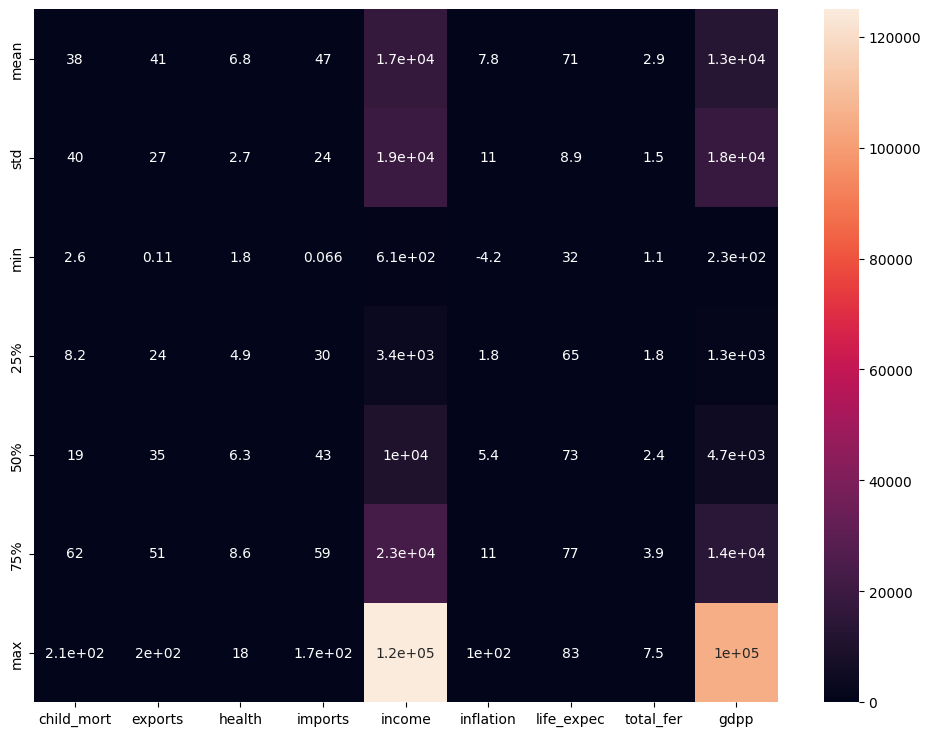

In [12]:
plt.figure(figsize=(12,9))
sns.heatmap(df.describe().drop('count', axis=0), annot=True)

### Looking at the distribution of the data

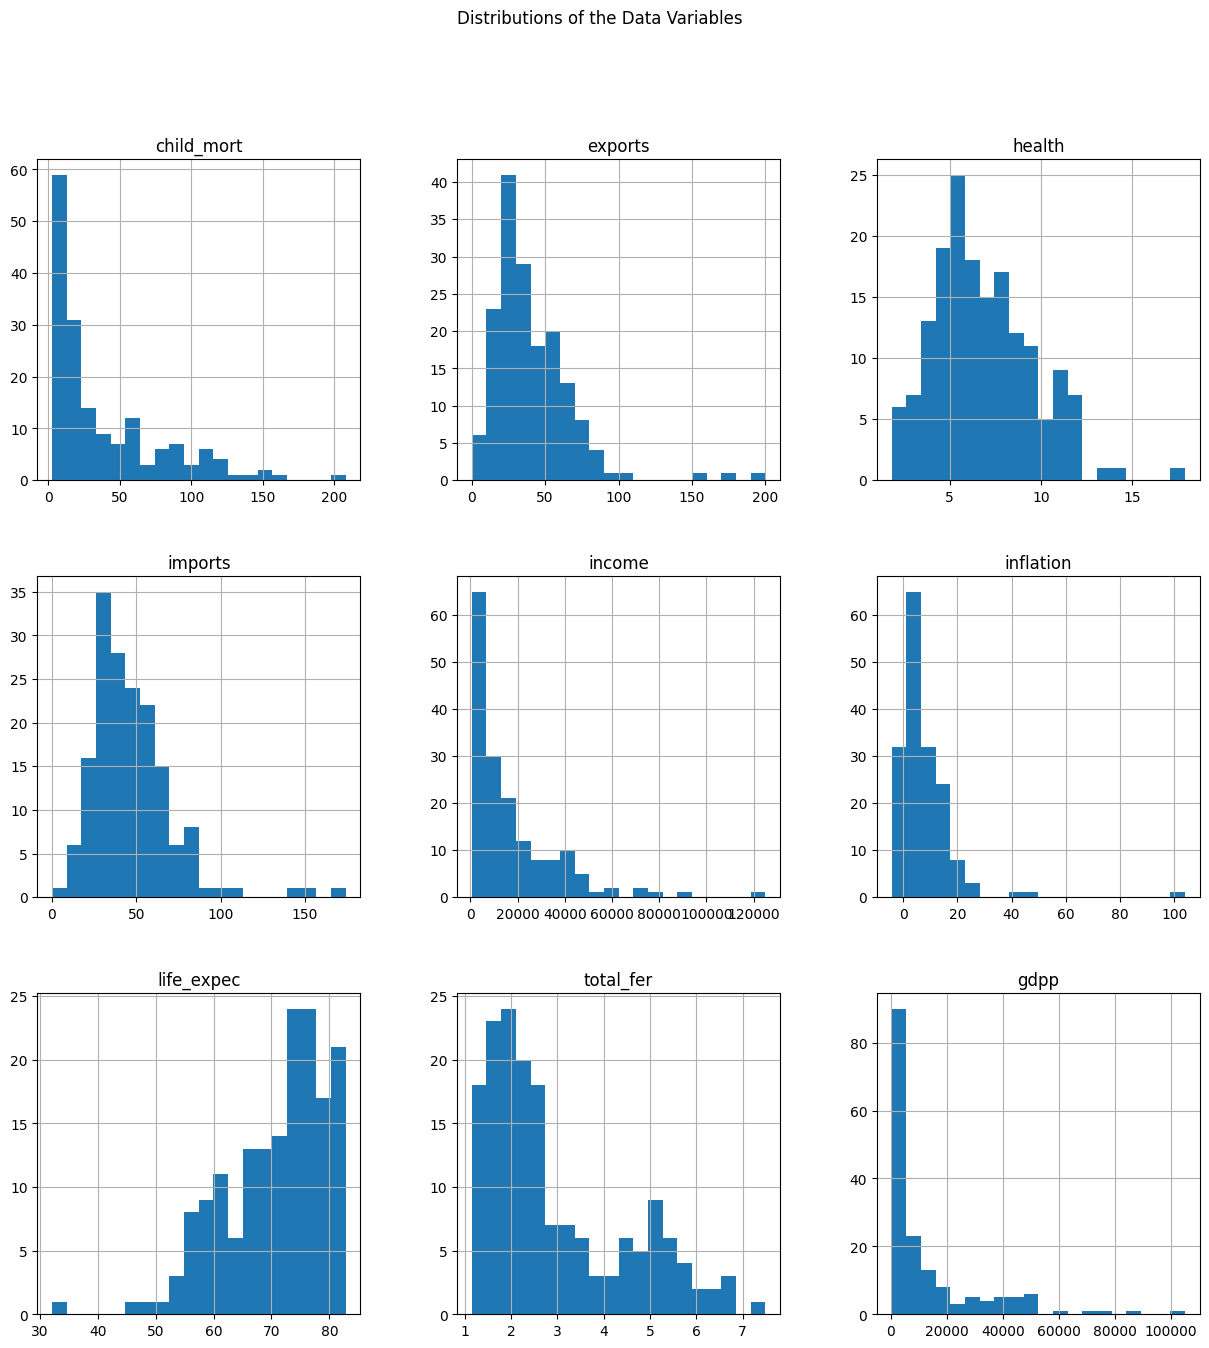

In [14]:
df.hist(bins=20, figsize=(15,15))
plt.suptitle('Distributions of the Data Variables')
plt.show()

Every variable is skewed in one way or the other. However this is to be expected because every country has outliers when looking at data like this. As a result, I won't be making any changes to reduce the outliers as they are quite necessary.

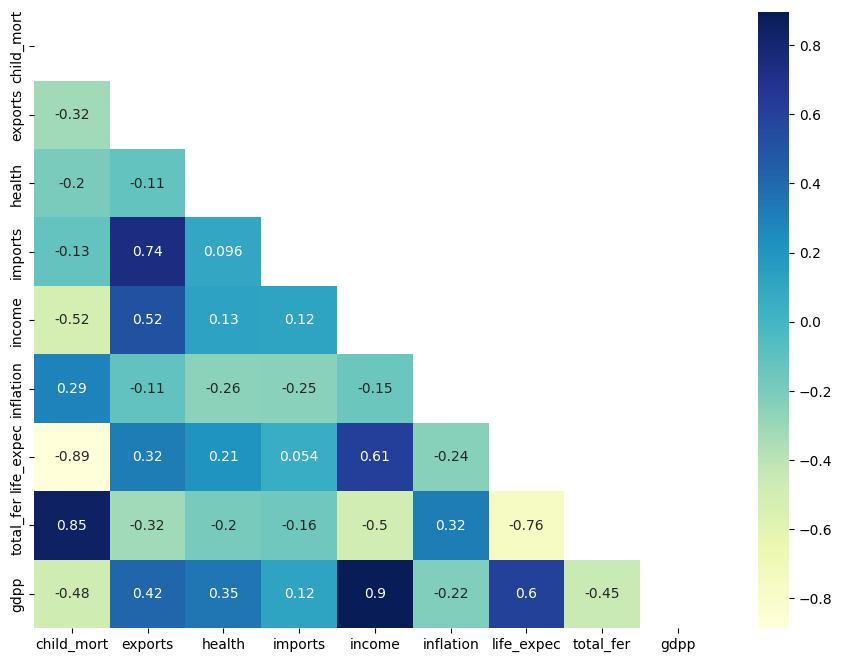

In [23]:
plt.figure(figsize=(11,8))
upper_triangle = np.triu(df.corr(numeric_only=True))
corr_mat = df.corr(numeric_only=True)
sns.heatmap(corr_mat, annot=True, cmap="YlGnBu", mask=upper_triangle)
plt.show()

There are quite a few strong correlations, again as expected. A higher child mortality rate is typically associated with a lower life expectancy, and a higher overall income is typically associated with a higher GDP per capita.

### Scaling the data

The data needs to be scaled simply because the values are too drastic when compared to each other acorss the whole set. While we'd expect the income to be substantially higher overall than inflation, for example, the models may struggle to compare them. Such variance can really badly affect the performance of the model, especially given that it is based on measuring distances. 

Moving forward, the country column won't be useful, so it can be dropped here and picked back up at the end.

In [61]:
data = df.drop('country', axis=1)
data1 = data.copy()
data

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [26]:
## to be used later when putting the standardised dataset into its own new dataframe
result_col = data.columns

## using standard scaler
sscaler = StandardScaler()
sc_data = sscaler.fit_transform(data)
sc_data


array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

In [27]:
sc_data = pd.DataFrame(data = sc_data, columns = result_col)
sc_data

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754


We now have access to the standardised version of the original dataset.

In [32]:
pca = PCA(n_components=4)
pca.fit(sc_data)
pca_data = pca.transform(sc_data)
pca_data = pd.DataFrame(data=pca_data)
pca_data

,0,1,2,3
0,-2.913025,0.095621,-0.718118,1.005255
1,0.429911,-0.588156,-0.333486,-1.161059
2,-0.285225,-0.455174,1.221505,-0.868115
3,-2.932423,1.695555,1.525044,0.839625
4,1.033576,0.136659,-0.225721,-0.847063
...,...,...,...,...
162,-0.820631,0.639570,-0.389923,-0.706595
163,-0.551036,-1.233886,3.101350,-0.115311
164,0.498524,1.390744,-0.238526,-1.074098
165,-1.887451,-0.109453,1.109752,0.056257


I will now be using both the standardised dataset and the pca dataset to go ahead with the models 

### K-Means Clustering

#### Preparation

First we need to see the ideal number of clusters

In [35]:
elb_plot = []
k_rnge = range(1,10)
for k in k_rnge:
    km = KMeans(n_clusters=k)
    km.fit(sc_data)
    elb_plot.append(km.inertia_)

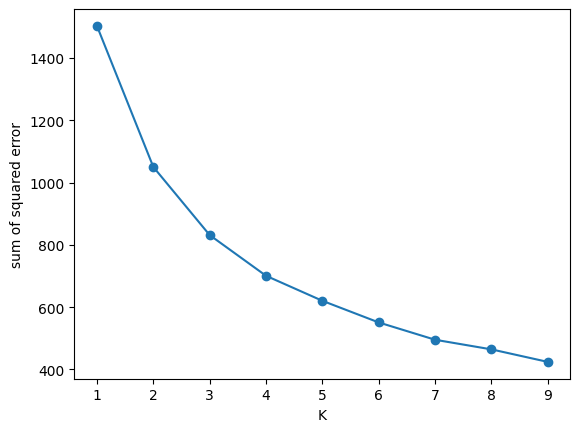

In [37]:
## plot the elbow chart
plt.xlabel('K')
plt.ylabel('sum of squared error')
plt.plot(k_rnge,elb_plot, marker='o')

3 seems to be the ideal number of clusters for that dataset. I could go ahead and run the same method with the PCA dataset, but I will use 3 anyway.

#### Modelling

In [38]:
km = KMeans(n_clusters=3)
y_pred_sc = km.fit_predict(sc_data)
y_pred_sc

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [43]:
sc_data['cluster'] = y_pred_sc
sc_data['cluster'].value_counts()

cluster
1    84
2    47
0    36
Name: count, dtype: int64

In [40]:
y_pred_pca = km.fit_predict(pca_data)
y_pred_pca

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [42]:
data['cluster'] = y_pred_pca
data['cluster'].value_counts()

cluster
2    84
1    48
0    35
Name: count, dtype: int64

The results seem to be very similar besides one difference in the clusters, and an issue with the clusters being the same but labeled differently. As a result I am just going to stick with the standard scaled results instead.

In [45]:
data.drop('cluster', axis=1, inplace=True)

In [51]:
df['cluster'] = y_pred_sc
data['cluster'] = y_pred_sc
data

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,2


Text(0.5, 0.98, 'Clusters compared by feature')

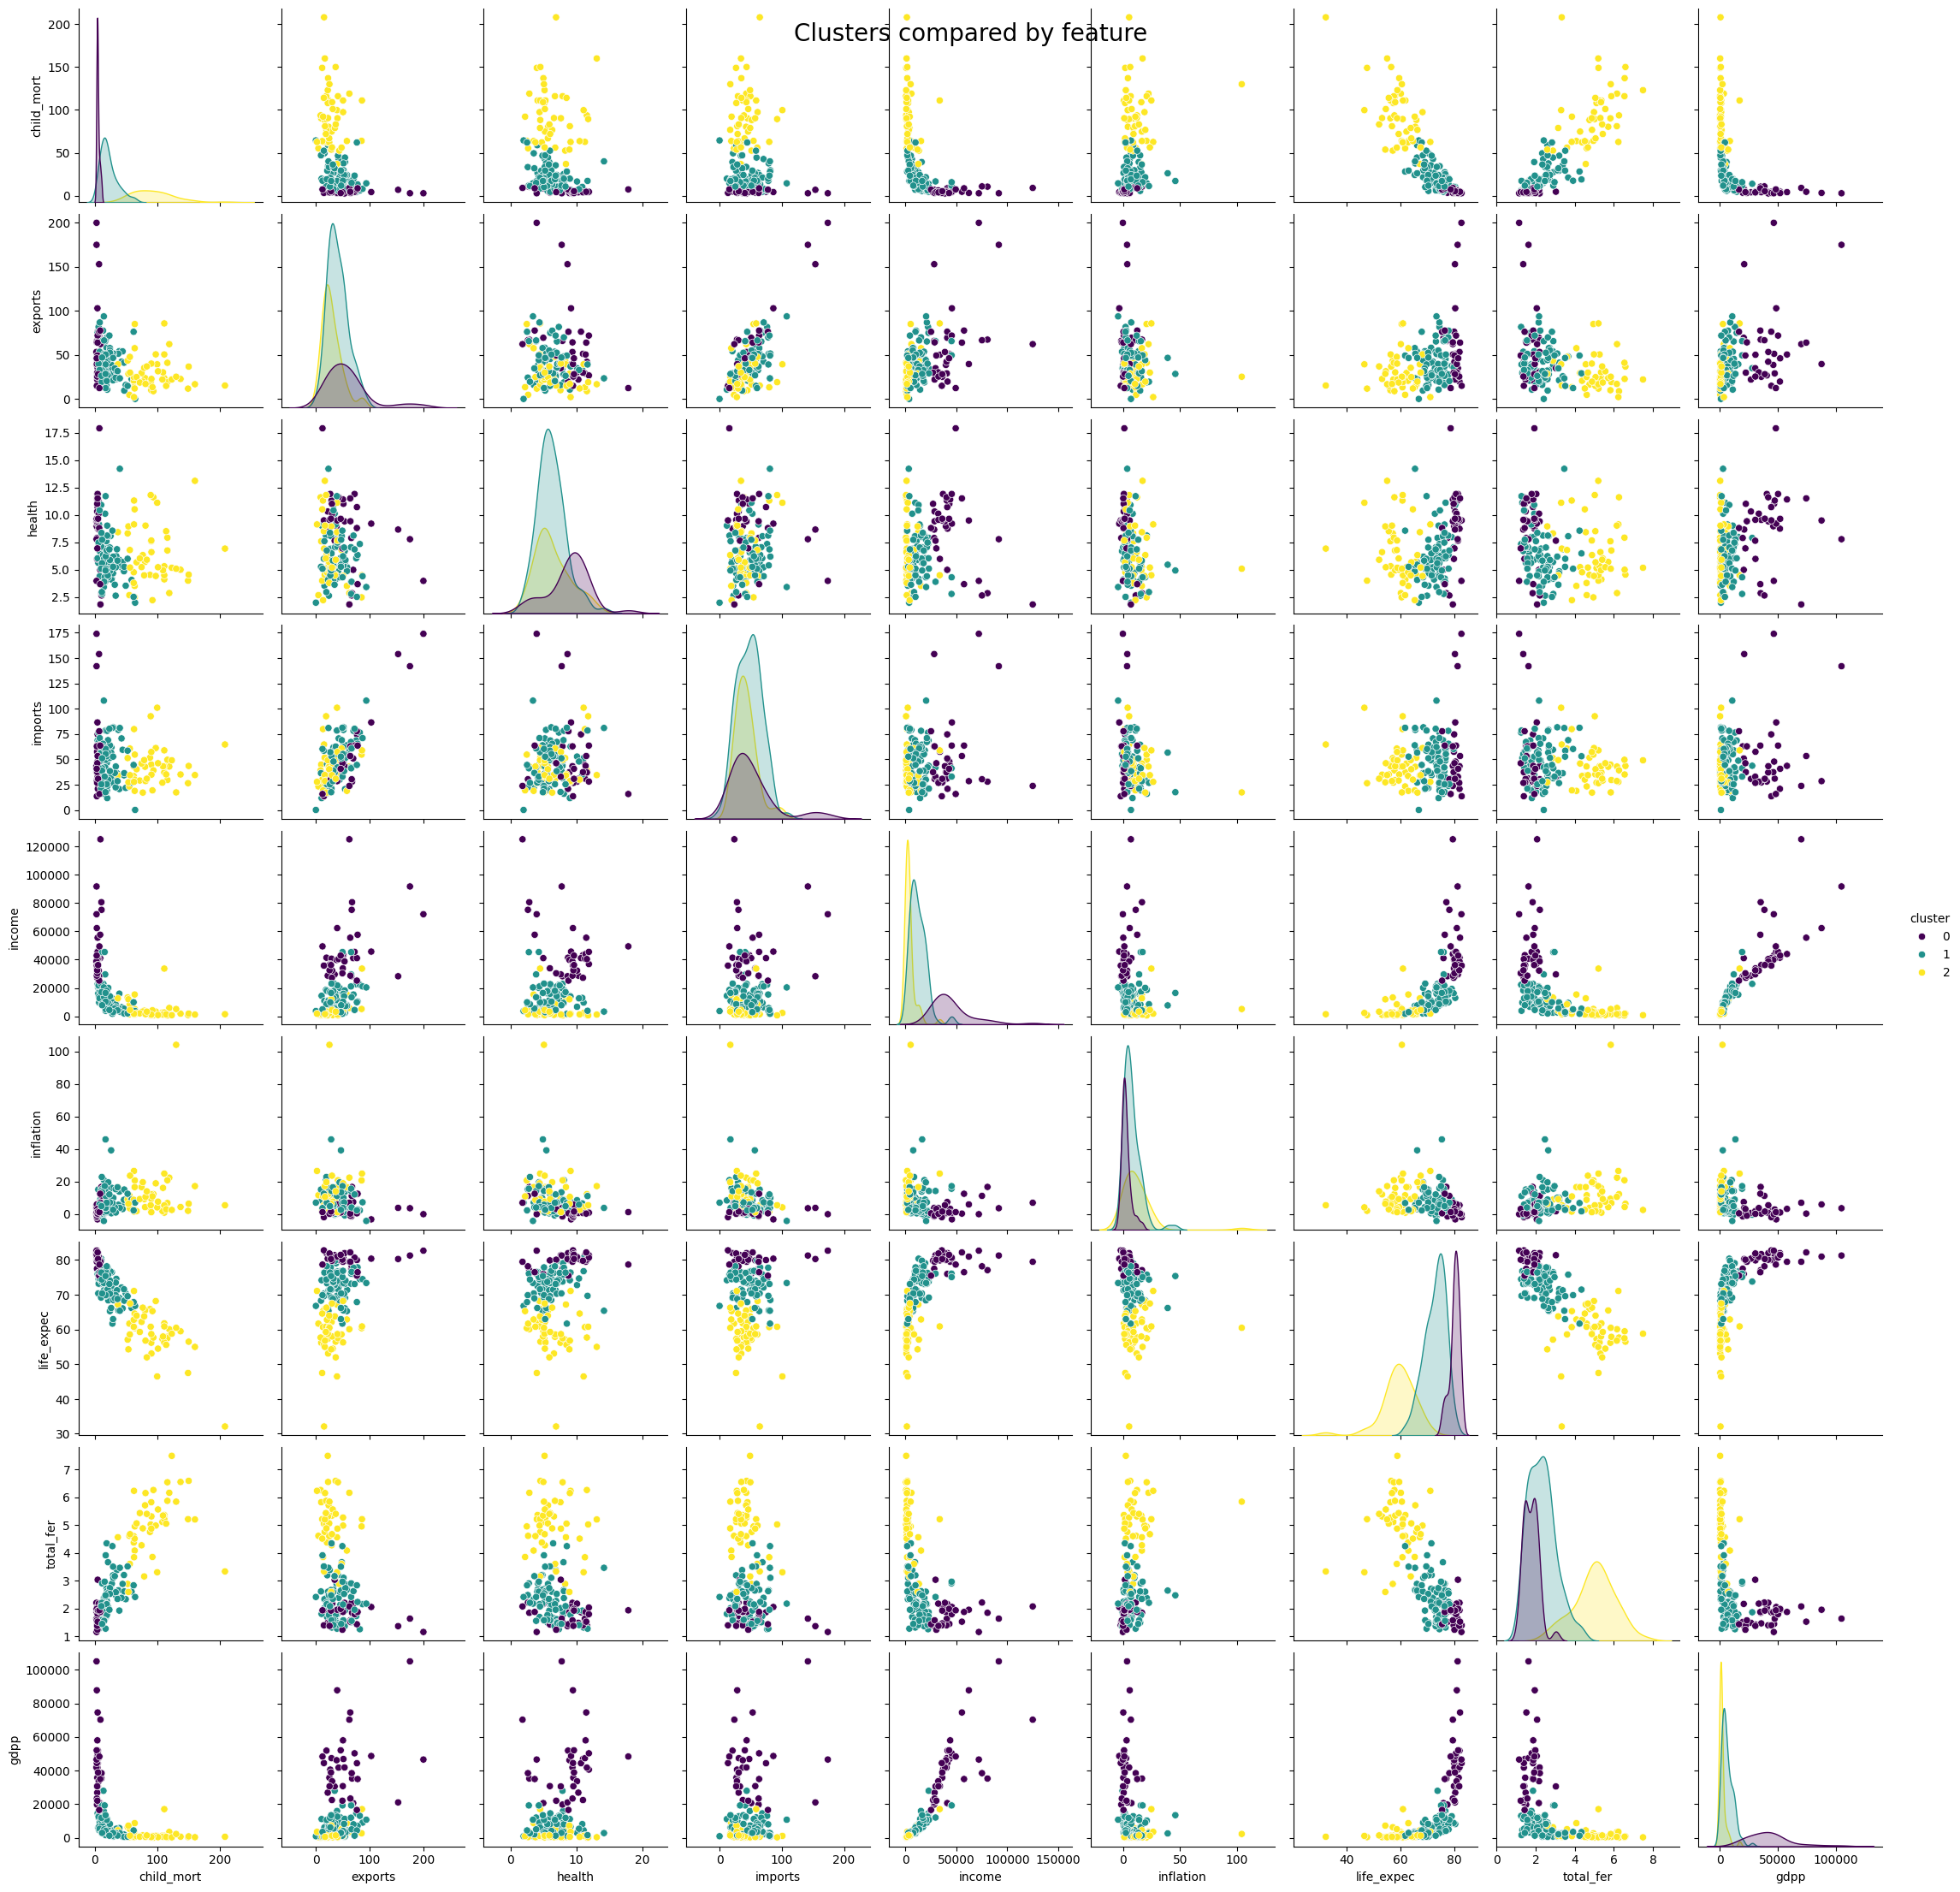

In [50]:
sns.pairplot(data, hue='cluster', palette='viridis')
plt.suptitle('Clusters compared by feature', size=20)

There is a lot of overlap between clusters 1 and 2 for various features, while cluster 0 seems to be more independent and spread out for the most part.

In [53]:
clusters = pd.pivot_table(data, index=['cluster'])
clusters

,child_mort,exports,gdpp,health,imports,income,inflation,life_expec,total_fer
cluster,,,,,,,,,
0,5.000000,58.738889,42494.444444,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778
1,21.927381,40.243917,6486.452381,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500
2,92.961702,29.151277,1922.382979,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085


In [54]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,2


In [69]:
score = silhouette_score(sc_data, km.labels_, metric='euclidean')
print('Silhouette Score: ', score)

Silhouette Score:  0.3109025276409065


#### Findings

It seems that cluster 2 would be in the most need of the extra support from the charity.

In [57]:
countries = df.loc[df['cluster']==2]
countries.country

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

### Agglomerative Clustering

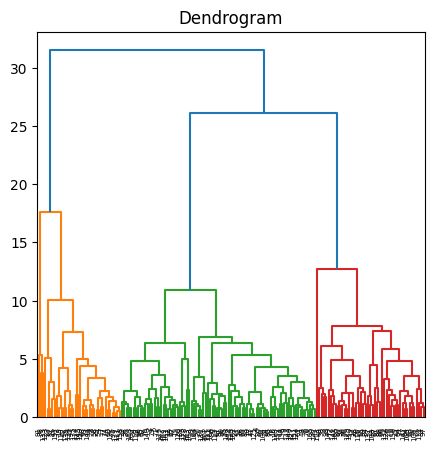

In [78]:
##dendrogram
plt.figure(figsize=(5,5))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(sc_data, method='ward'))

plt.show()

In [59]:
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
y_pred_agg = agg.fit_predict(sc_data)
y_pred_agg

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1], dtype=int64)

In [66]:
data1['cluster'] = y_pred_agg
df1['cluster'] = y_pred_agg
data1['cluster'].value_counts()

cluster
2    88
1    45
0    34
Name: count, dtype: int64

Text(0.5, 0.98, 'Clusters compared by feature')

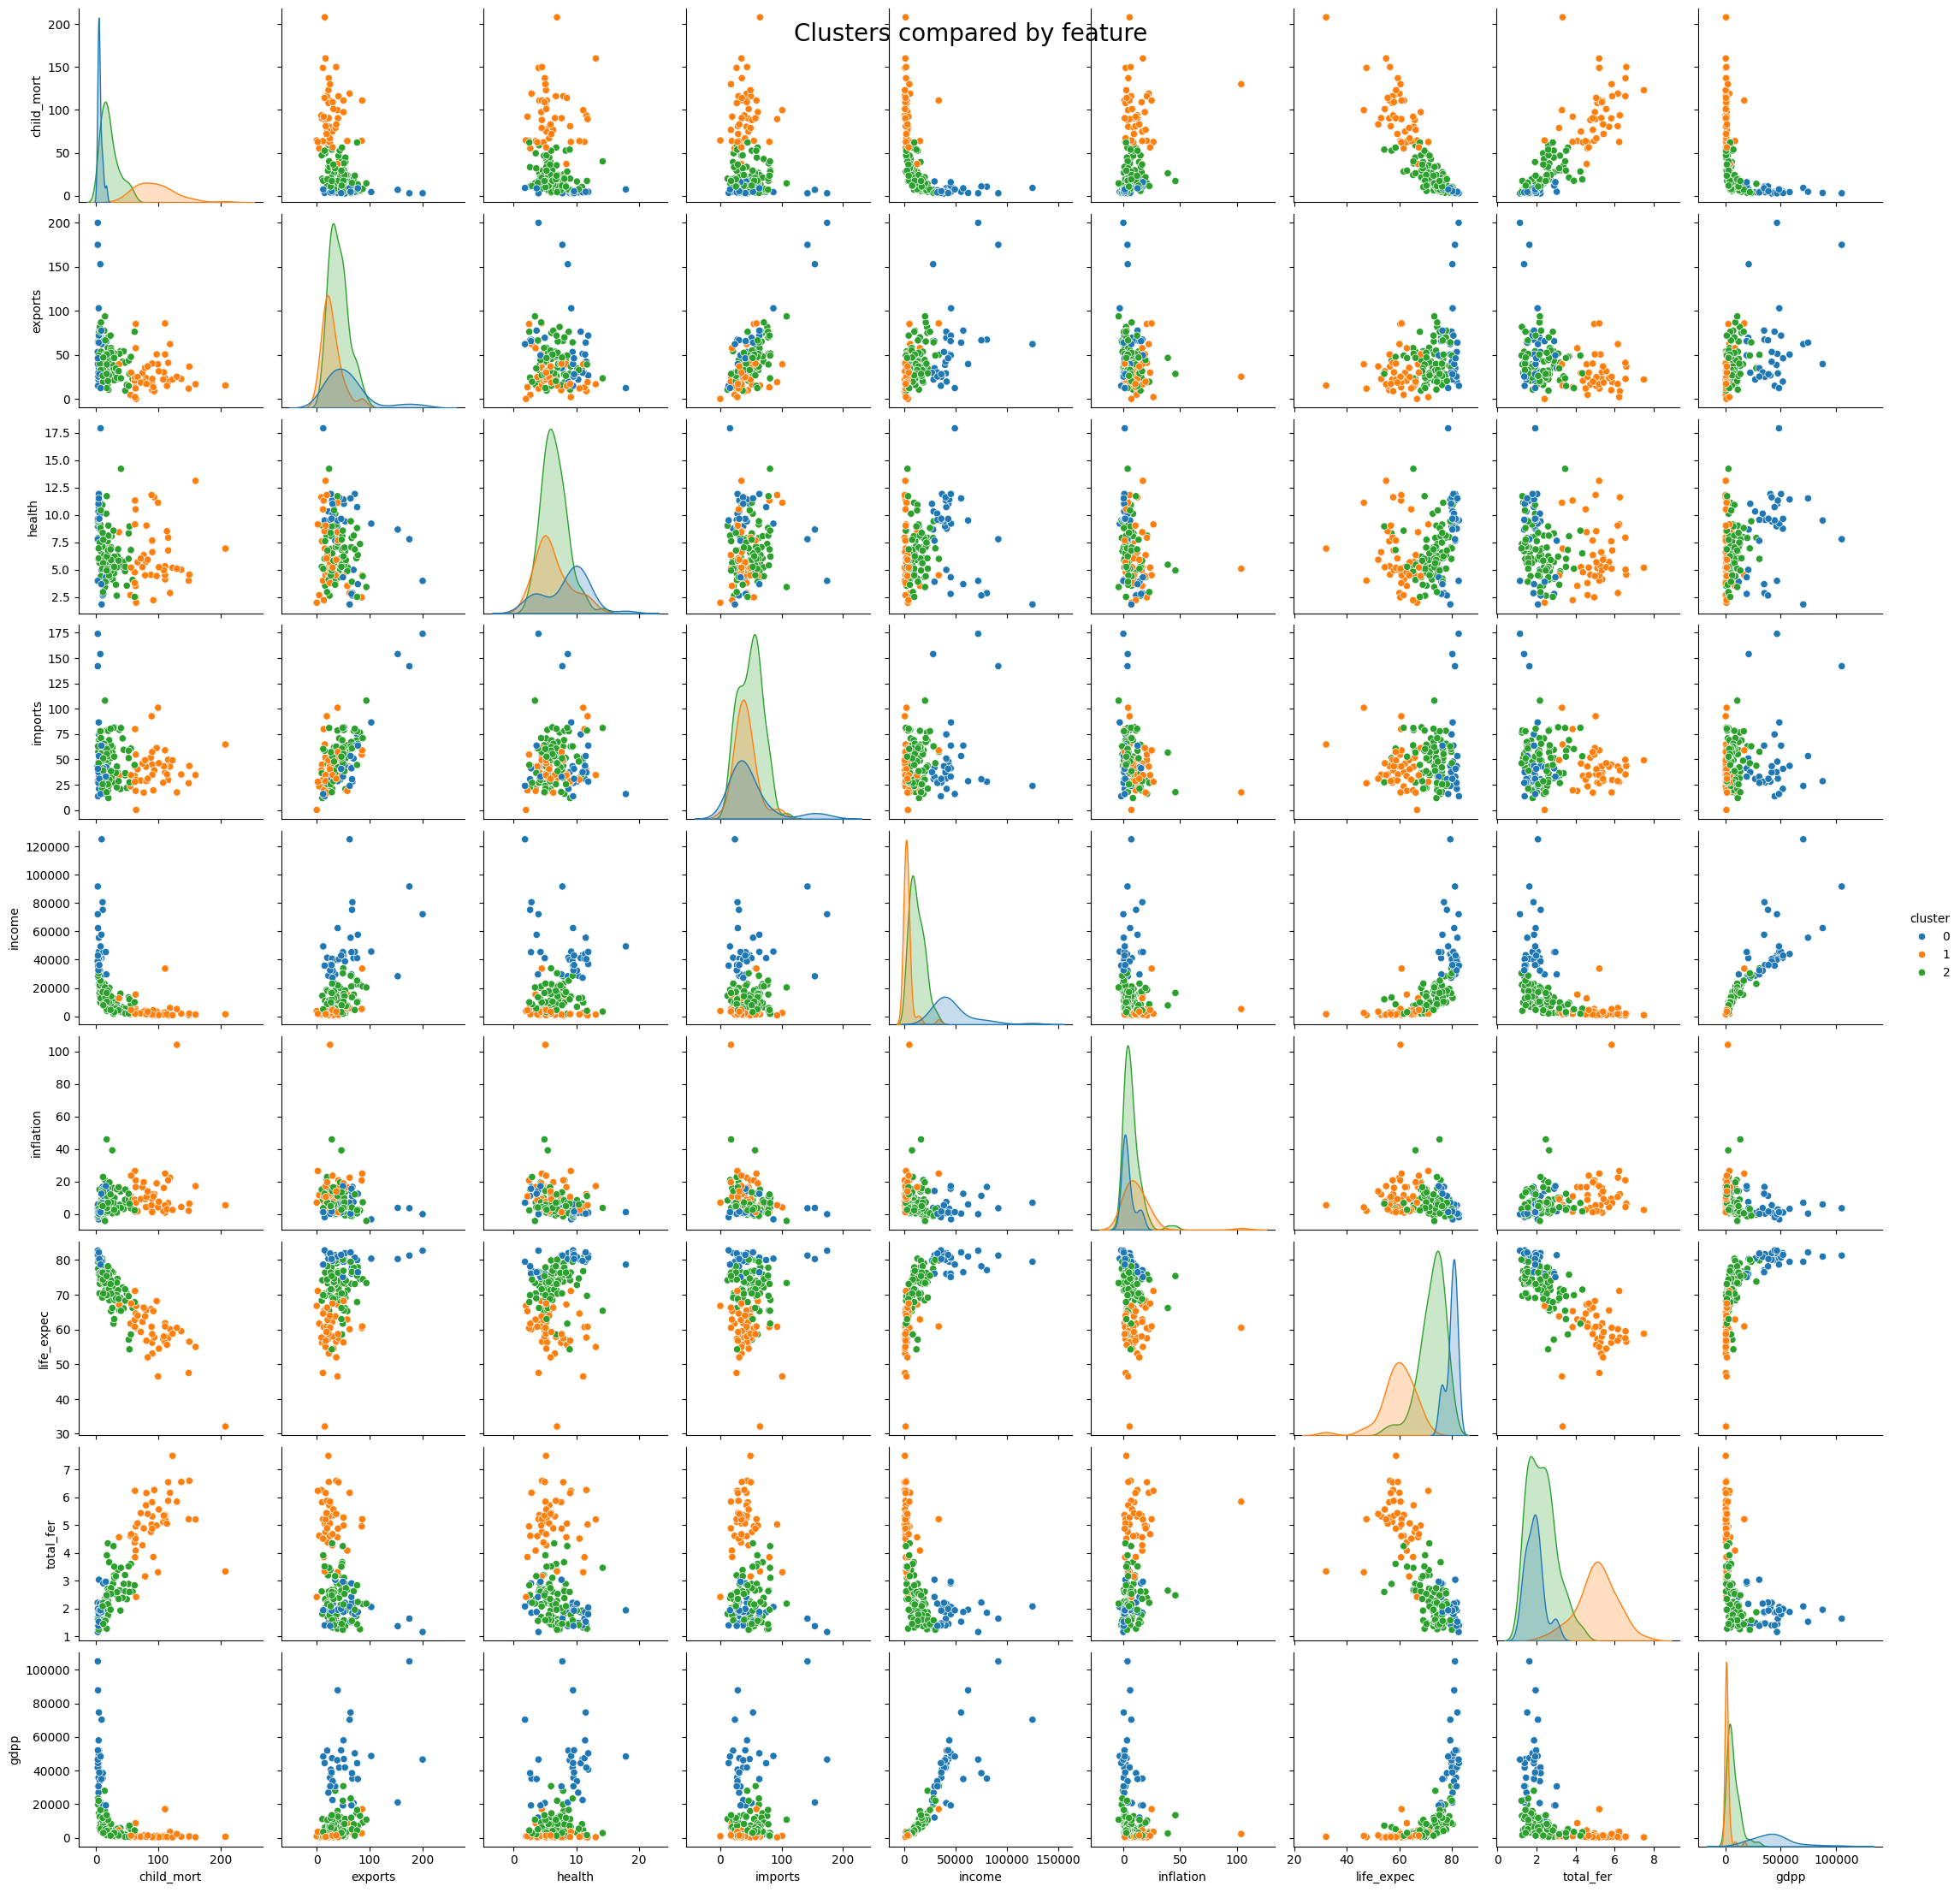

In [64]:
sns.pairplot(data1, hue='cluster', palette='tab10')
plt.suptitle('Clusters compared by feature', size=20)

In [65]:
clusters1 = pd.pivot_table(data1, index=['cluster'])
clusters1

,child_mort,exports,gdpp,health,imports,income,inflation,life_expec,total_fer
cluster,,,,,,,,,
0,5.961765,58.508824,43170.588235,8.501176,48.902941,47588.235294,4.115500,79.982353,1.888529
1,94.920000,27.782644,1611.555556,6.182444,41.108131,3450.066667,12.291889,59.524444,5.082667
2,21.784091,41.200909,7098.795455,6.488295,49.069318,12385.340909,6.892091,72.554545,2.265682


In [67]:
countries1 = df1.loc[df1['cluster']==1]
countries1.country

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
107     

In [72]:
km1 = KMeans(n_clusters=4)
ypred = km1.fit_predict(sc_data)
ypred

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 3, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [76]:
score = silhouette_score(sc_data, km1.labels_, metric='euclidean')
print('Silhouette Score: ', score)

Silhouette Score:  0.37642041827565764


In [73]:
sc_data['cluster1'] = ypred
sc_data['cluster1'].value_counts()

cluster1
2    84
1    47
0    33
3     3
Name: count, dtype: int64

In [75]:
data['cluster1'] = ypred
clusters1 = pd.pivot_table(data, index=['cluster1'])
clusters1

,child_mort,exports,gdpp,health,imports,income,inflation,life_expec,total_fer
cluster1,,,,,,,,,
0,5.078788,48.078788,41124.242424,8.990909,41.930303,44003.030303,2.689727,80.009091,1.786667
1,92.961702,29.151277,1922.382979,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085
2,21.927381,40.243917,6486.452381,6.200952,47.473404,12305.595238,7.600905,72.814286,2.307500
3,4.133333,176.000000,57566.666667,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000
